In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from datetime import datetime,timedelta
import scipy.optimize as opt

jhu_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
jhu = pd.read_csv(jhu_url)
numeric_cols = [col for col in jhu if jhu[col].dtype.kind != 'O']
cols = numeric_cols[5:]
jhu[cols] += 1

In [2]:
####### ONLY THINGS TO CHANGE #####################
### will not work if day has not happened yet or already happened when prediction dataset was created 
day = '5/6/20' 
prediction_file = 'v2_pred_10days_from05032020.csv'
###################################################


def analyze_day(day = datetime.strftime(datetime.now() - timedelta(1), '%Y-%m-%d'), verbose = True):
    yest_pred = pd.read_csv(prediction_file)
    true_idx = pd.to_datetime(jhu.columns.values, errors= 'coerce') == pd.to_datetime(day)
    pred_idx = pd.to_datetime(yest_pred.columns.values, errors= 'coerce') == pd.to_datetime(day)
    true_vals = np.array(jhu.iloc[:,true_idx])
    pred_ = np.array(yest_pred.iloc[:,pred_idx])
    
    x = np.square(np.log(true_vals) - np.log(pred_))
    y = true_vals - pred_
    
    # log loss basically just means we measure predictions by % off
    # prediction 10 vs real value 5 is equally as bad as prediction 100,000 vs real value 50,000

    # Example in how to interpret first one (more than 2): 
    # the percentage of cases that predicted really bad (loss over 2) was 14%
    # but the average amount of cases from the group that was poorly predicted was 6.7 
    # (i.e. counties really small case counts predict poorly)

    if verbose: 
        print('PREDICTIONS FOR: ', day, '\n\n\n')

        print('TOTAL average loss: ',
              np.average(np.square(np.log(true_vals) - np.log(pred_))), '\n')
        
        print('TOTAL sum loss for cases over 100:\n # Cases: ', len(true_vals[true_vals >100]), '\n',
              np.sum(np.square(np.log(true_vals[true_vals >100]) - np.log(pred_[true_vals >100]))), '\n')
        
        print('TOTAL average loss for cases over 100:\n # Cases: ', len(true_vals[true_vals >100]), '\n',
              np.average(np.square(np.log(true_vals[true_vals >100]) - np.log(pred_[true_vals >100]))), '\n')
        
        #print('TOTAL average loss for pred over 100:\n # Cases: ', len(true_vals[pred_ >100]), '\n',
         #     np.average(np.square(np.log(true_vals[pred_ >100]) - np.log(pred_[pred_ >100]))), '\n')
        
        print('TOTAL average loss for cases over 50:\n # Cases: ', len(true_vals[true_vals >50]), '\n',
              np.average(np.square(np.log(true_vals[true_vals >50]) - np.log(pred_[true_vals >50]))), '\n')
        
        #print('TOTAL average loss for pred over 50:\n # Cases: ', len(true_vals[pred_ >50]), '\n',
          #    np.average(np.square(np.log(true_vals[pred_ >50]) - np.log(pred_[pred_ >50]))), '\n')
            
        print('TOTAL average loss for cases over 30:\n # Cases: ', len(true_vals[true_vals >30]), '\n',
              np.average(np.square(np.log(true_vals[true_vals >30]) - np.log(pred_[true_vals >30]))), '\n')
        
        print('TOTAL average loss for cases UNDER 30:\n # Cases: ', len(true_vals[true_vals <30]), '\n',
              np.average(np.square(np.log(true_vals[true_vals <30]) - np.log(pred_[true_vals <30]))), '\n',
             'average # cases: ', np.average(true_vals[true_vals <30]), 'average pred: ', np.average(pred_[true_vals <30]), '\n')

        print('Cases missing by more than 2 (~ 300% off - ex. pred = 40, true = 10): ', '\nPercent: ', round(len(x[x>2])/len(x),2), 
              '\naverage num cases: ',np.average(true_vals[x>2]), '\n') 
        print('Cases missing by more than 1 (~ 175% off): ', '\nPercent: ', round(len(x[x>1])/len(x),2), 
              '\naverage num cases: ',np.average(true_vals[x>1]), '\n')
        print('Cases missing by less than 1 (~ 175% off): ', '\nPercent: ', round(len(x[x<1])/len(x),2), 
              '\naverage num cases: ',np.average(true_vals[x<1]), '\n')
        print('Cases missing by less than 0.5 (~ 100% off): ', '\nPercent: ', round(len(x[x<0.5])/len(x),2), 
              '\naverage num cases: ',np.average(true_vals[x<0.5]), '\n')
        print('Cases missing by less than 0.1 (~ 35% off): ', '\nPercent: ', round(len(x[x<0.1])/len(x),2), 
              '\naverage num cases: ',np.average(true_vals[x<0.1]), '\n')
        print('Cases missing by less than 0.01 (~10% off): ', '\nPercent: ', round(len(x[x<0.01])/len(x),2), 
              '\naverage num cases: ',np.average(true_vals[x<0.01]), '\n')
        print('Cases missing by less than 0.001 (~4% off): ', '\nPercent: ', round(len(x[x<0.001])/len(x),2), 
              '\naverage num cases: ',np.average(true_vals[x<0.001]), '\n')
        print('average loss if removing losses above 1: ',
              np.average(np.square(np.log(true_vals[x<1]) - np.log(pred_[x<1]))), '\n')
        print('average loss if removing losses above 0.5: ',
              np.average(np.square(np.log(true_vals[x<0.5]) - np.log(pred_[x<0.5]))), '\n')
        
        print('total predictions: ', len(y))
        print('\n# of Overpredictions: ', len( y[y<0]), '\navg cases in overpredictions', np.average(true_vals[y<0])
             , '\n avg overprediction by', np.average(y[y<0]))
        print('\n# of Underpredictions: ',len(y[y>0]), '\navg cases in underpredictions', np.average(true_vals[y>0])
             , '\n avg underprediction by', np.average(y[y>0]))


        print('\nTotal avg cases: ', np.average(true_vals), '\nTotal miss average (by %): ', np.average(np.absolute(y)))
        plt.hist(x, bins = 30, range = (0, 2))
        plt.title('distribution of log loss on each prediction')
        plt.ylabel('number of counties')
        plt.show()
        plt.hist(y, bins = 30, range = (-300,300))
        plt.title('distribution of prediction misses')
        plt.show()
        z = pred_/true_vals
        plt.hist(z, bins = 30, range = (0,5))
        plt.title('distribution of percent prediction misses')
        plt.show()
    
    return x, y 

PREDICTIONS FOR:  5/12/20 



TOTAL average loss:  1.5560357760014485 

TOTAL sum loss for cases over 100:
 # Cases:  870 
 270.8624403690526 

TOTAL average loss for cases over 100:
 # Cases:  870 
 0.3113361383552329 

TOTAL average loss for cases over 50:
 # Cases:  1213 
 0.3240334025654601 

TOTAL average loss for cases over 30:
 # Cases:  1499 
 0.35468139287008205 

TOTAL average loss for cases UNDER 30:
 # Cases:  1744 
 2.601365961808731 
 average # cases:  8.870412844036696 average pred:  21.227754257604065 

Cases missing by more than 2 (~ 300% off - ex. pred = 40, true = 10):  
Percent:  0.2 
average num cases:  15.324850299401197 

Cases missing by more than 1 (~ 175% off):  
Percent:  0.28 
average num cases:  20.64138678223185 

Cases missing by less than 1 (~ 175% off):  
Percent:  0.72 
average num cases:  579.0346449957228 

Cases missing by less than 0.5 (~ 100% off):  
Percent:  0.62 
average num cases:  667.599700897308 

Cases missing by less than 0.1 (~ 35% off):

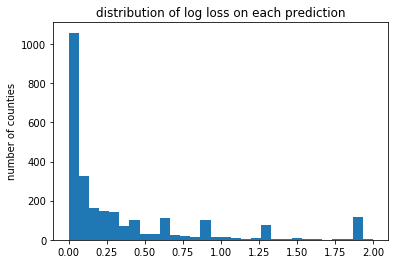

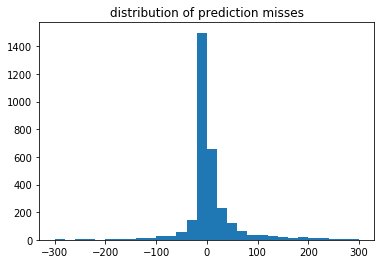

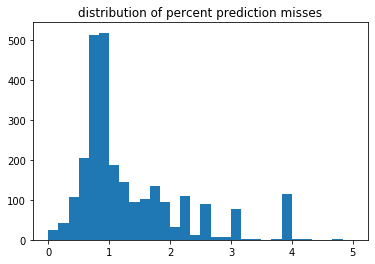

In [13]:
# can run this for any day that was predicted and has already happened
day = '5/12/20' 
sq_log_loss, miss = analyze_day(day, verbose = True)